# Segmenting an image of greek coins into regions

This demo follows the sklearn image segmentation example available at https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_segmentation.html

That example uses spectral clustering to identify connected pixel regions of similar grayscale in an image. Spectral clustering is well suited for image segmentation tasks as it naturally works with graph Laplacians that can encode neighborhood information about nodes (in this case, the nodes are the pixels of an image). In such a way, the method favours clustering nearby pixels together, tending to produce connected regions.

CLASSIX is primarily a distance-based clustering method, but we can encode affinity information of pixels as additional features of the data points. More precisely, we can represent each grayscale pixel as a 3D point of the form `[ c, scl*x, scl*y ]`, where `c` is the colour value, and `x, y` are the pixel coordinates. The scaling parameter `scl` is used to control the relative weighting between colour and position of a pixel.

The CLASSIX clustering result is shown at the end of this notebook.

In [ ]:
!pip install classixclustering

## Spectral clustering

Spectral clustering: kmeans, 5.88s
Spectral clustering: discretize, 3.23s
Spectral clustering: cluster_qr, 3.17s


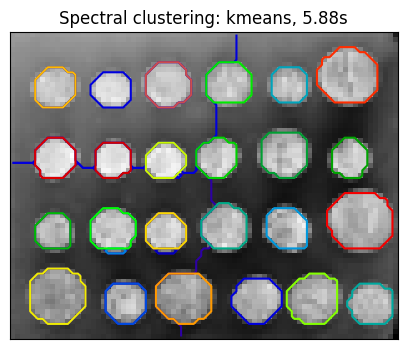

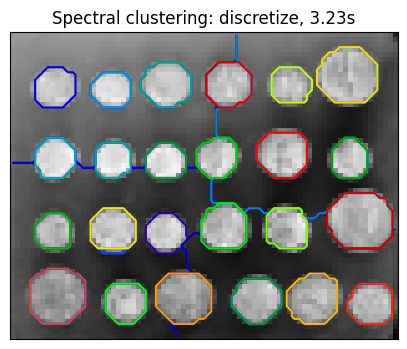

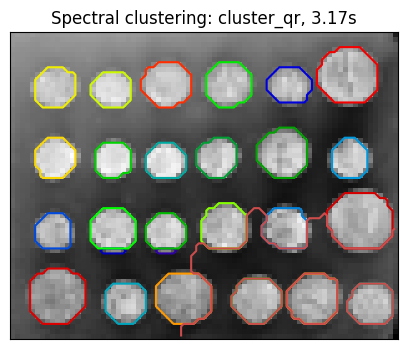

In [36]:
# This cell is taken without modifications from
# https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_segmentation.html
# as of November 2023

# Author: Gael Varoquaux <gael.varoquaux@normalesup.org>
#         Brian Cheung
#         Andrew Knyazev <Andrew.Knyazev@ucdenver.edu>
# License: BSD 3 clause

import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.data import coins
from skimage.transform import rescale

from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

# load the coins as a numpy array
orig_coins = coins()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", anti_aliasing=False)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(rescaled_coins)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# The number of segmented regions to display needs to be chosen manually.
# The current version of 'spectral_clustering' does not support determining
# the number of good quality clusters automatically.
n_regions = 26

# Computing a few extra eigenvectors may speed up the eigen_solver.
# The spectral clustering quality may also benetif from requesting
# extra regions for segmentation.
n_regions_plus = 3

# Apply spectral clustering using the default eigen_solver='arpack'.
# Any implemented solver can be used: eigen_solver='arpack', 'lobpcg', or 'amg'.
# Choosing eigen_solver='amg' requires an extra package called 'pyamg'.
# The quality of segmentation and the speed of calculations is mostly determined
# by the choice of the solver and the value of the tolerance 'eigen_tol'.
# TODO: varying eigen_tol seems to have no effect for 'lobpcg' and 'amg' #21243.
for assign_labels in ("kmeans", "discretize", "cluster_qr"):
    t0 = time.time()
    labels = spectral_clustering(
        graph,
        n_clusters=(n_regions + n_regions_plus),
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=1,
    )

    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)

    plt.xticks(())
    plt.yticks(())
    title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)
        # To view individual segments as appear comment in plt.pause(0.5)
plt.show()

## CLASSIX

We now run CLASSIX. The below clustering depends primarily on two parameters, namely `scl` which controls how much weighting is given to the distance between pixels relative to their grayscale values, and `radius` which controls the coarseness of clusters. These parameters required some fine-tuning, but the result is surprisingly good.

CLASSIX(radius=0.03, minPts=20, group_merging='distance')
CLASSIX aggregated the 4697 data points into 4697 groups. 
In total, 140910 distances were computed (30.0 per data point). 
The 4697 groups were merged into 422 clusters.
The largest 20 clusters have the following sizes:
  2899,108,97,93,84,68,62,62,60,54,53,52,48,46,44,44,41,37,36,35,...
As minPts is 20, the number of clusters has been reduced to 25.
Use the verbose=0 parameter to suppress this info.
Use the .explain() method to explain the clustering.
CLASSIX clustering: 0.61s



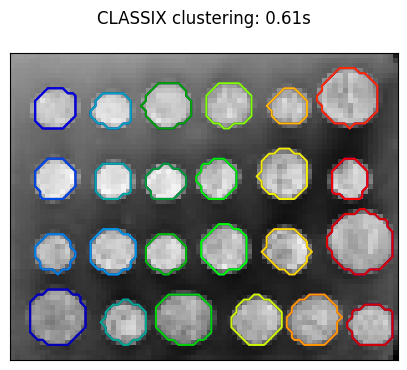

In [38]:
'''
   CLASSIX
   In order to promote locality between neighboring pixels, we encode their
   x-y coordinates as two additional components in the feature vectors.
'''

ny, nx = rescaled_coins.shape
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))
scl = 0.08 # locality weighing
data = np.c_[rescaled_coins.flatten(), scl*X.flatten(), scl*Y.flatten()]

from classix import CLASSIX
clx = CLASSIX(radius=0.03, minPts=20, verbose=1)
t0 = time.time()
clx.fit(data)
t1 = time.time()

labels = clx.labels_.reshape(rescaled_coins.shape)
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)

plt.xticks(())
plt.yticks(())
title = "CLASSIX clustering: %.2fs\n" % (t1-t0)
print(title)
plt.title(title)
for l in range(np.max(clx.labels_)+1):
    colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
    plt.contour(labels == l, colors=colors)
    # To view individual segments as appear comment in plt.pause(0.5)
    #plt.pause(0.5)

Note that CLASSIX has identified 25 clusters. These correspond to the 24 coins plus the image background (the contour plot of which is the rectangle enclosing the whole image).

Finally, calling CLASSIX's explain method leads to fascinating output: it essentially regenerates the original image without "knowing" that the provided 3D data matrix corresponded to an image!

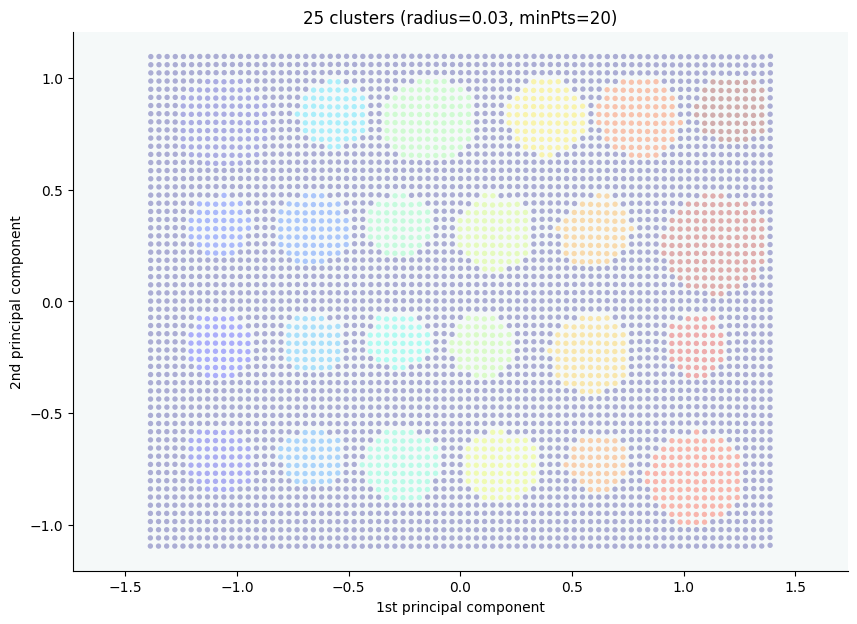

CLASSIX clustered 4697 data points with 3 features.
The radius parameter was set to 0.03 and minPts was set to 20.
As the provided data was auto-mergeScaled by a factor of 1/2.19,
points within a radius R=0.03*2.19=0.07 were grouped together.
In total, 140910 distances were computed (30.0 per data point).
This resulted in 4697 groups, each with a unique group center.
These 4697 groups were subsequently merged into 25 clusters. 

To explain the clustering of individual data points, use
 .explain(index1) or .explain(index1,index2) with data indices.


In [39]:
clx.explain(plot=True)